In [7]:
iter = 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.datasets import fashion_mnist, cifar10, cifar100, mnist
from keras.models import *
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for quantization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Dataset

In [2]:
# Carga del dataset, dividido en trainig y testing (data y clase)
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

# One-hot encoding
n_classes = 10
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

## FC NN definition for prunning

#### WARNING
when using keras from raw imports, model is of class `Sequential` instead of `keras.models.Sequential` and that makes `prune_low_magnitude` throw a Class error. Fixed by removing all raw keras imports and using `tensorflow.keras.models.Sequentials` manually...

In [21]:
# MLP architecture
w = 28
h = 28
n_classes = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(w, h)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

# training params
lr = 0.01
op = tf.keras.optimizers.SGD(lr)

model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()

# training stage
history = model.fit(x_train_norm, y_train, epochs= 16, batch_size = 50, validation_split=0.2)

# evaluation stage
test_loss, test_acc = model.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dropout_11 (Dropout)        (None, 20)               

## Prunning

In [22]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = tf.keras.optimizers.Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2

final_sparsity = 0.6

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

# create prunned model
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# compile prunned model
modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [23]:
iter += 1

# fit new prunned model
historyP = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/16
750/750 [==============================] - 9s 6ms/step - loss: 0.5476 - accuracy: 0.8292 - val_loss: 0.1723 - val_accuracy: 0.9507
Epoch 2/16
750/750 [==============================] - 4s 5ms/step - loss: 0.2116 - accuracy: 0.9427 - val_loss: 0.1519 - val_accuracy: 0.9576
Epoch 3/16
750/750 [==============================] - 4s 6ms/step - loss: 0.1528 - accuracy: 0.9575 - val_loss: 0.1190 - val_accuracy: 0.9668
Epoch 4/16
750/750 [==============================] - 6s 8ms/step - loss: 0.1165 - accuracy: 0.9676 - val_loss: 0.1120 - val_accuracy: 0.9702
Epoch 5/16
750/750 [==============================] - 5s 6ms/step - loss: 0.1015 - accuracy: 0.9719 - val_loss: 0.1087 - val_accuracy: 0.9720
Epoch 6/16
750/750 [==============================] - 8s 10ms/step - loss: 0.0918 - accuracy: 0.9748 - val_loss: 0.1081 - val_accuracy: 0.9716
Epoch 7/16
750/750 [==============================] - 9s 12ms/step - loss: 0.0831 - accuracy: 0.9768 - val_loss: 0.1017 - val_accuracy: 0.9740
Epoc

In [24]:
modelP.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n_5 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_dense_  (None, 192)               301250    
 35 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_  (None, 128)               49282     
 36 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t_10 (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_dense_  (None, 128)              

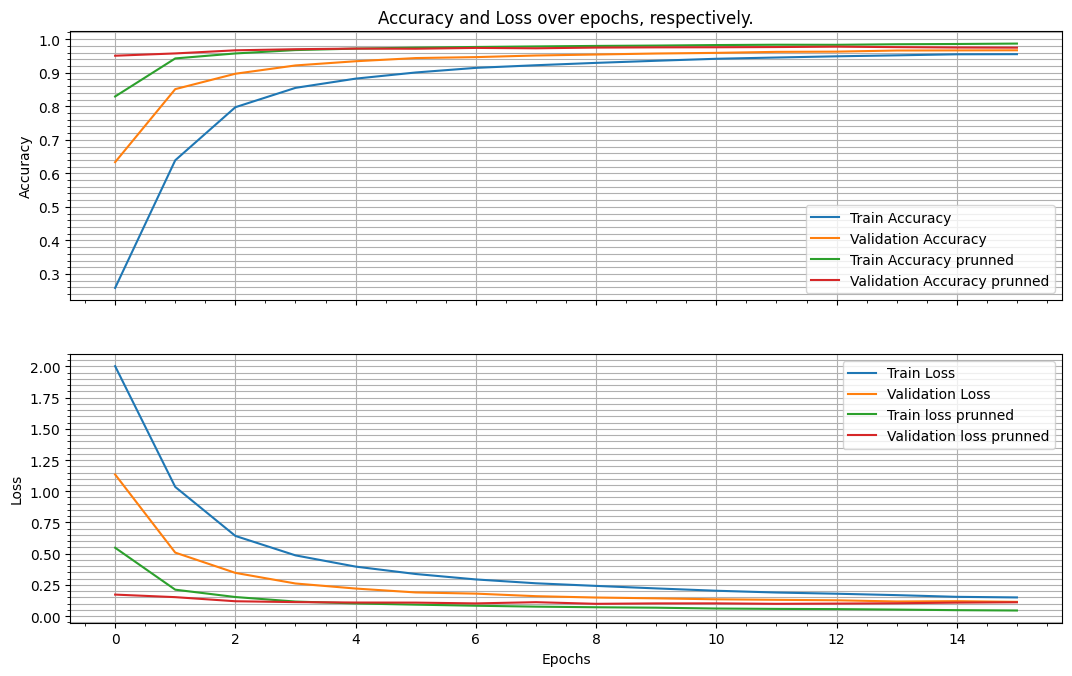

In [26]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(historyP.history['accuracy'], label='Train Accuracy prunned')
ax1.plot(historyP.history['val_accuracy'], label='Validation Accuracy prunned')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.plot(historyP.history['loss'], label='Train loss prunned')
ax2.plot(historyP.history['val_loss'], label='Validation loss prunned')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_acc_n_loss_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

In [25]:
modelP_stripped = strip_pruning(modelP)

modelP_stripped.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 192)               150720    
                                                                 
 dense_36 (Dense)            (None, 128)               24704     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

### Cambio de sparsity

Al aumentar el sparsity, luego del segundo entrenamiento con prunning, se obtiene cada vez menos accuracy y mayor loss, de todas formas en general se suele mejorar el desempeño de la red.

## Quantization

### QAT: Quantization-aware training

El modelo se re-define haciendo uso de **QKeras**, una extensión de Keras diseñada para crear y entrenar modelos de redes neuronales con cuantización. Su principal objetivo es optimizar modelos para hardware con recursos limitados, como FPGAs, microcontroladores y aceleradores embebidos.

- Permite definir pesos y activaciones con diferentes niveles de precisión (por ejemplo, 8 bits, 4 bits, ternario (-1, 0, 1), etc.).

- Al reducir la precisión numérica, disminuye el uso de memoria y el costo computacional.

- Facilita la conversión de modelos cuantizados en implementaciones eficientes para FPGAs, garantizando la compatibilidad con hls4ml.

- Compatible con capas estándar de Keras, pero con soporte adicional para configuraciones de precisión baja.

Una vez redefinido el modelo a entrenear mediante QKeras, se procede al entrenamiento del mismo. 

In [24]:
## Quantization
from qkeras import *

## Estrategia de cuantización

## Definición del número de bits para kernel, bias, y activación.
# 8-bits
kernelQ = "quantized_bits(6,3,alpha=1)"
biasQ = "quantized_bits(6,3,alpha=1)"
activationQ = 'quantized_bits(6,3)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

c:\.neuralEnv\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [25]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 100)               78500     
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 fc2 (QDense)                (None, 50)                5050      
                                                                 
 relu2 (QActivation)         (None, 50)                0         
                                                                 
 dropout_13 (Dropout)        (None, 50)             

In [26]:
# Entrenamiento

import tensorflow.keras.backend as K

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16
750/750 [==============================] - 4s 4ms/step - loss: 1.4160 - accuracy: 0.6847 - val_loss: 0.7131 - val_accuracy: 0.8191
Epoch 2/16
750/750 [==============================] - 2s 3ms/step - loss: 0.8628 - accuracy: 0.7698 - val_loss: 0.6202 - val_accuracy: 0.8354
Epoch 3/16
750/750 [==============================] - 2s 3ms/step - loss: 0.8005 - accuracy: 0.7778 - val_loss: 0.5018 - val_accuracy: 0.8583
Epoch 4/16
750/750 [==============================] - 2s 3ms/step - loss: 0.7154 - accuracy: 0.7975 - val_loss: 0.4982 - val_accuracy: 0.8482
Epoch 5/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6668 - accuracy: 0.8074 - val_loss: 0.4294 - val_accuracy: 0.8751
Epoch 6/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6407 - accuracy: 0.8132 - val_loss: 0.4909 - val_accuracy: 0.8572
Epoch 7/16
750/750 [==============================] - 3s 3ms/step - loss: 0.6468 - accuracy: 0.8131 - val_loss: 0.4409 - val_accuracy: 0.8780
Epoch 

#### Metrics

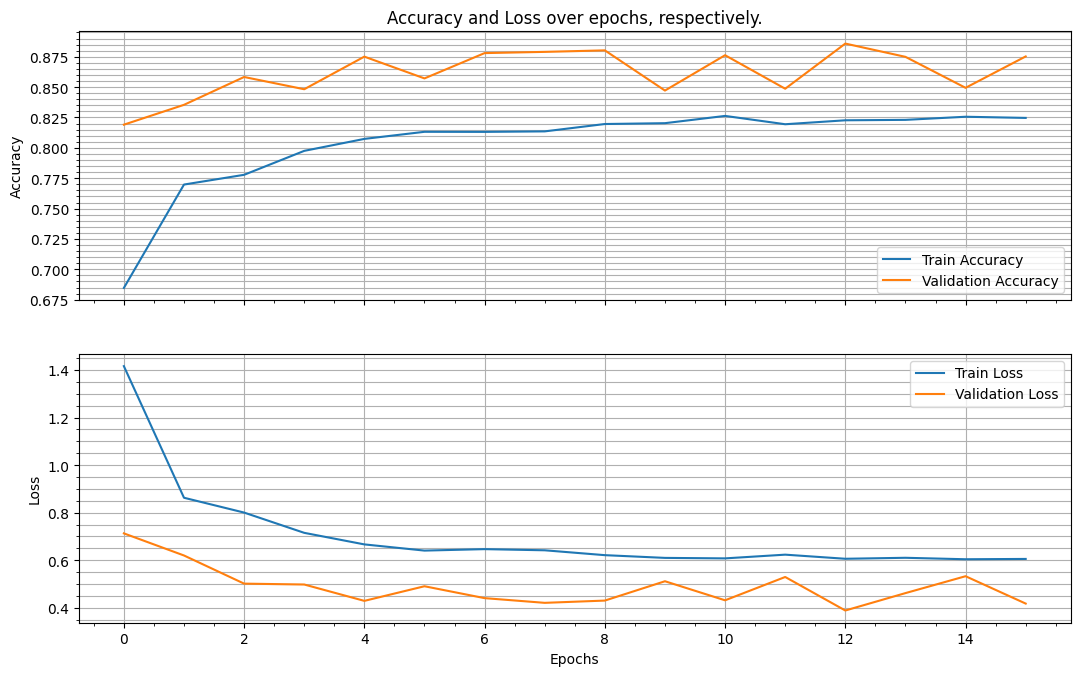

In [27]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyQAT.history['accuracy'], label='Train Accuracy')
ax1.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyQAT.history['loss'], label='Train Loss')
ax2.plot(historyQAT.history['val_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAT_6bit_3bit_acc_n_loss_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

313/313 [==============================] - 1s 2ms/step


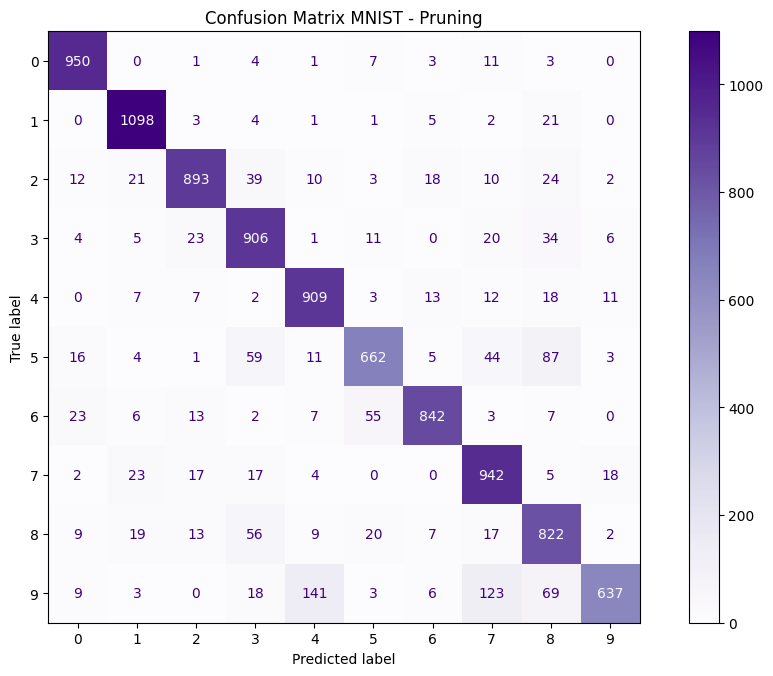

In [28]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAT_6bit_3bit_confusion_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

### QAP: Quantization-aware prunning

Quantization-aware pruning (QAP) combina pruning con quantization-aware training. El objetivo es reducir el tamaño del modelo luego de cuantizarlo, para obtener una red más eficiente sin sacrificar precisión.

In [29]:
# defino parametros para prunning
final_sparsity = 0.3

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

In [31]:
# defino nuevamente la arquitectura cuantizada

## Definición del número de bits para kernel, bias, y activación.
# 8-bits

kernelQ = "quantized_bits(6,3,alpha=1)"
biasQ = "quantized_bits(6,3,alpha=1)"
activationQ = 'quantized_bits(6,3)'

modelQ = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

In [32]:
# Entrenamiento, cuantizado y con prunning
iter += 1

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAP = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

modelQAP.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAP = modelQAP.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
                )

Epoch 1/16
750/750 [==============================] - 7s 5ms/step - loss: 1.3766 - accuracy: 0.6876 - val_loss: 0.5686 - val_accuracy: 0.8442
Epoch 2/16
750/750 [==============================] - 3s 4ms/step - loss: 0.8259 - accuracy: 0.7753 - val_loss: 0.5307 - val_accuracy: 0.8532
Epoch 3/16
750/750 [==============================] - 3s 4ms/step - loss: 0.7671 - accuracy: 0.7802 - val_loss: 0.5124 - val_accuracy: 0.8482
Epoch 4/16
750/750 [==============================] - 3s 4ms/step - loss: 0.7107 - accuracy: 0.7941 - val_loss: 0.4832 - val_accuracy: 0.8716
Epoch 5/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6726 - accuracy: 0.8058 - val_loss: 0.4388 - val_accuracy: 0.8741
Epoch 6/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6309 - accuracy: 0.8138 - val_loss: 0.5008 - val_accuracy: 0.8508
Epoch 7/16
750/750 [==============================] - 3s 4ms/step - loss: 0.6300 - accuracy: 0.8135 - val_loss: 0.4253 - val_accuracy: 0.8716
Epoch 

#### Metricas

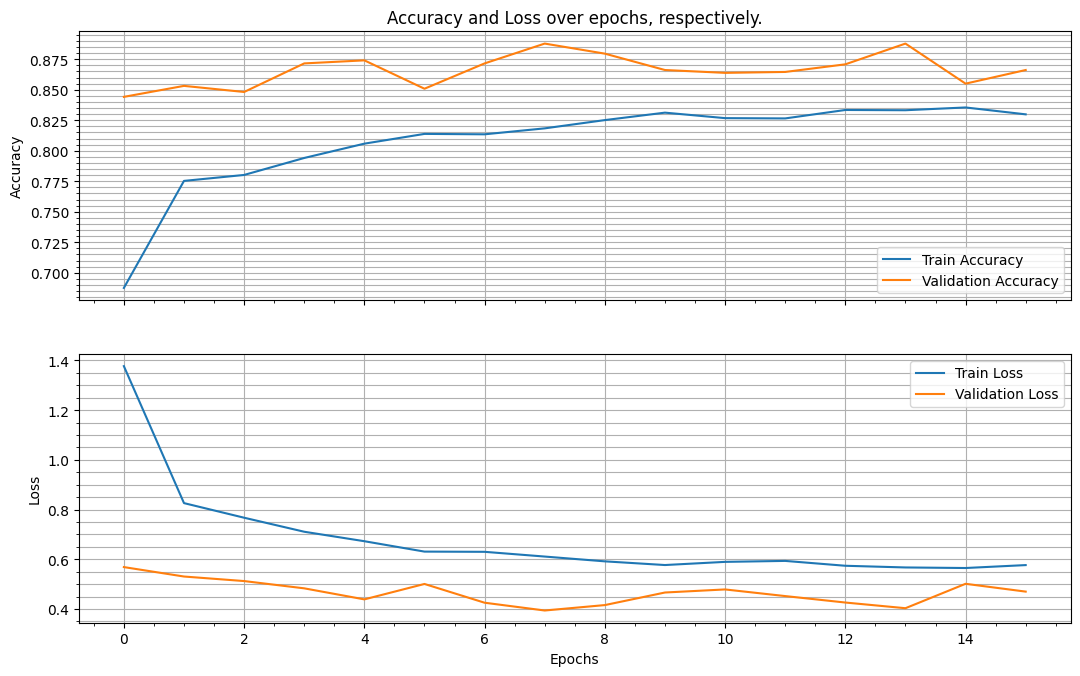

In [33]:
# Plot accuracy and loss over epochs
ax1 = plt.subplot(211)
ax1.plot(historyQAP.history['accuracy'], label='Train Accuracy')
ax1.plot(historyQAP.history['val_accuracy'], label='Validation Accuracy')
ax1.minorticks_on()
ax1.tick_params('x', labelbottom=False)
ax1.grid(visible=True, which='both', axis='y')
ax1.grid(visible=True, which='Major', axis='x')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over epochs, respectively.')
ax1.legend()

ax2 = plt.subplot(212)
ax2.plot(historyQAP.history['loss'], label='Train Loss')
ax2.plot(historyQAP.history['val_loss'], label='Validation Loss')
ax2.minorticks_on()
ax2.grid(visible=True, which='both', axis='y')
ax2.grid(visible=True, which='Major', axis='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAP_6bit_3bit_acc_n_loss_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

313/313 [==============================] - 1s 2ms/step


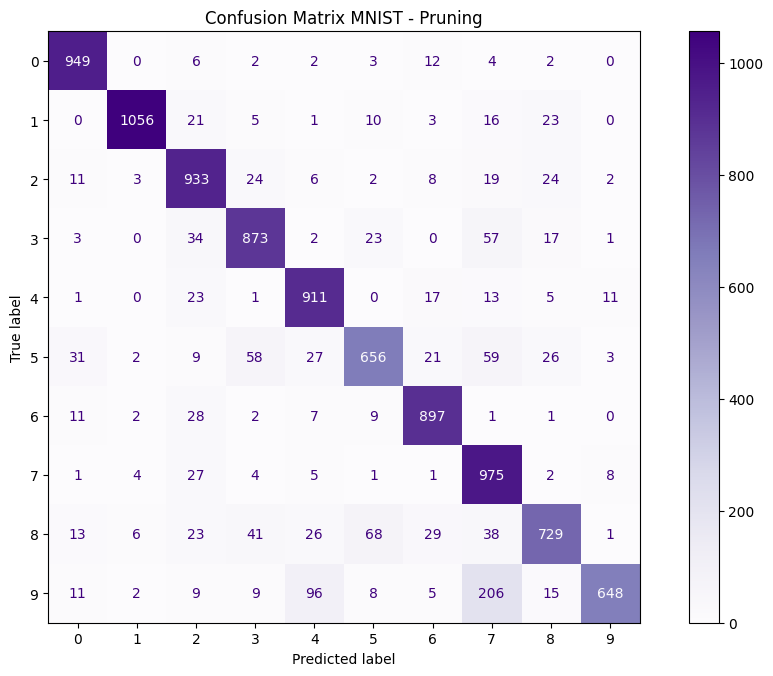

In [34]:
y_pred_probs = modelQAP.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')

fig = plt.gcf()
fig.set_size_inches(1280/fig.dpi, 768/fig.dpi)
plt.savefig("../img/Compression_QAP_6bit_3bit_confusion_iter-" + str(iter) + ".png", bbox_inches='tight')

plt.show()

In [35]:
modelQAT.summary()

modelQAP_stripped = strip_pruning(modelQAP)
modelQAP_stripped.summary()

modelQAT.save('../models/mnist_Model_FCNN_QAT_6b_3b.h5')
modelQAP_stripped.save('../models/mnist_Model_FCNN_QAP_6b_3b_prunned.h5')
# model.save('../models/mnist_Model_FCNN.h5')

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 100)               78500     
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 fc2 (QDense)                (None, 50)                5050      
                                                                 
 relu2 (QActivation)         (None, 50)                0         
                                                                 
 dropout_13 (Dropout)        (None, 50)             

Cuando se realiza prunning en una red de una sola capa...  
*poner que pasa cuando uso prunning en un perceptron simple*

Al ver la cantidad de parametros de los distintos modelos, todos tienen la misma cantidad...

... el modelo default entrenado pesa 700KB cuando es guardado
... el modelo en el que se efectuó QAT tiene 1MB aproximadamente cuando es guardado
... el modelo en el que se efectuó QAP (o sea quantizacion 8+4bits + prunning) tiene 300KB cuando es guardado

Al volver a generar QAT y QAP con menor cantidad de bits... (6b y 3b), ambos pesan lo mismo cuando se guardan los modelos, tiene sentido ya que la idea es entrenar la red para **prepararla** para quantizar, pero sin cuantizar; pero sí ocurre que la red entrenada con 6b-3b tiene peor accuracy en general y es mucho mas volátil en entrenamiento, lo que es consecuencia de tener menor precisión para cambiar los pesos sinapticos, el tunning de la red es menos fino.